In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation import *

/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


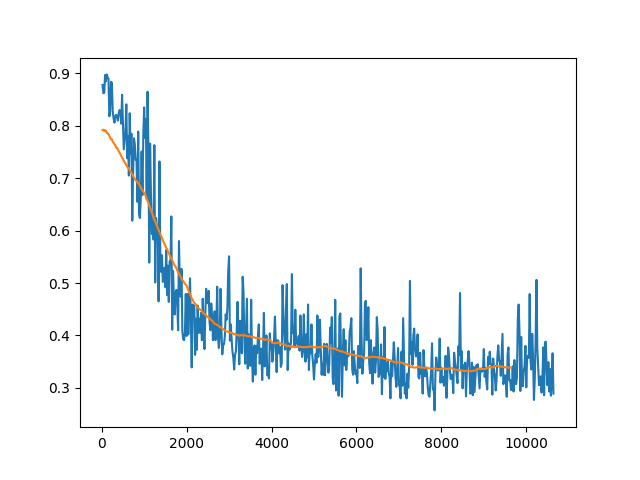

8660 0.33160396082566523 482
8240 0.33543564482490623


In [30]:
data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
# data_file = 'jsons/cifar_all_lr_1e_1.json'
# data_file = 'jsons/cifar_all_lr_8e_2.json'

with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 0
patience = 5
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 100
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])

In [31]:
'''
common parametes
'''
pred_win_size = 1000 # large enough to include all the points curretly acquired
left_tail_size = 0
period = 20
start_point = 5
num_samples = 100
upper_limit = 2e5 # it's acually equivalent to setting no upper limit because 2e5 is larger enough
noise_est_win_size = 1000

'''
result list
'''
all_preds = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None, 'method3': None}
all_errs = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None, 'method3': None}
all_steps = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None, 'method3': None}


In [32]:
'''
power_regression
'''
bnds = ((0, None), (None, 0))
inits = (1,0)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps,k,theta = method3(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size,
                                    linear_start_point = 100)

print(len(preds))
errs = CIs2errs(CIs)
all_preds['method3'] = preds
all_errs['method3'] = errs
all_steps['method3'] = steps

100
Predicted Stopping epoch is 274.8. a = 0.8416059434276815, b = 0.01039152876802622, skew = -0.050069440012229696, var = 0.00014977880058506882, k = 1595.5650801808904, theta = 0.0003063852916907891
500
Predicted Stopping epoch is 14545.0. a = 0.99469472725842, b = -0.030700452209611765, skew = 0.5480896107372564, var = 0.0006534279634032135, k = 13.315480762370523, theta = 0.007005198279313244
900
Predicted Stopping epoch is 13519.0. a = 1.232361730115119, b = -0.07480761830185975, skew = -0.9953700420597842, var = 0.0026834687135025162, k = 4.037298498892157, theta = 0.025781182784896828
1300
Predicted Stopping epoch is 12692.8. a = 1.389733257588994, b = -0.09738601655990611, skew = -0.6219023931930046, var = 0.005226447818081442, k = 10.342261992173464, theta = 0.022479960393428408
1700
Predicted Stopping epoch is 12639.6. a = 1.9511883503230327, b = -0.1591526388030697, skew = -0.5415842404793592, var = 0.00956598511453908, k = 13.637286189370618, theta = 0.026485054628936983
2

<IPython.core.display.Javascript object>


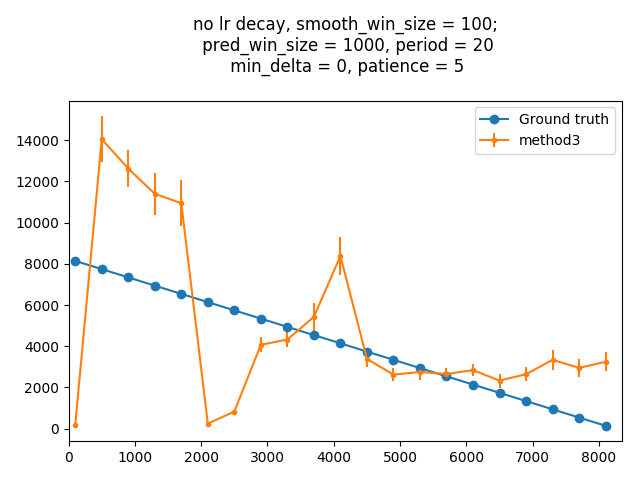

In [33]:
fig = plt.figure()
report_period = 20
# ground truth
x = (start_point+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
plt.plot(x, earlyStoppingStep-x,'-o')
legend = ['Ground truth']

# three methods
for alg in ['method3']:
    plt.errorbar(all_steps[alg], np.array(all_preds[alg])-np.array(all_steps[alg]), all_errs[alg], fmt='.-')
    legend.append(alg)
    
plt.xlim(0,earlyStoppingStep+100)
plt.legend(legend)
plt.title('no lr decay, smooth_win_size = {4};\n pred_win_size = {0}, period = {1}\n min_delta = {2}, patience = {3}\n '.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

# # save the image
# dir_ = '/Users/stranot/Desktop/resutls122318/cifar_subset_bs_32/'
# plt.savefig(dir_ + 'images/min_delta_{:.0e}_patience_{}.png'.format(min_delta, patience))

# # store the results
# for key in all_preds:
#     all_preds[key] = list(all_preds[key])
#     all_errs[key] = list(all_errs[key])
#     all_steps[key] = list(all_steps[key])
# output = {}
# output['all_preds'] = all_preds
# output['all_errs'] = all_errs
# output['all_steps'] = all_steps
# with open(dir_ + 'jsons/min_delta_{:.0e}_patience_{}.json'.format(min_delta, patience), 'w+') as f:
#     json.dump(output, f)

<IPython.core.display.Javascript object>


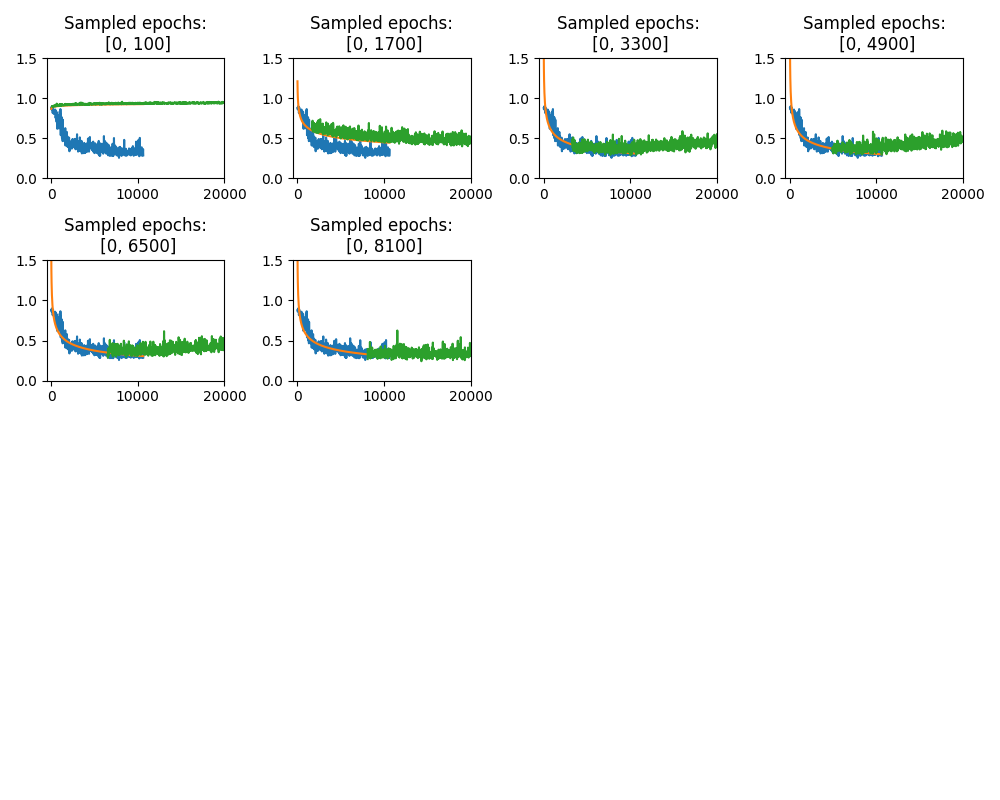

In [34]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
co = 0
step_size = 4
for i in range(0,len(coeffs),step_size):
    
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
    ax.plot(steps, val_err)
    ax.plot(steps[:len(val_err)],power_function(steps[:len(val_err)], coeffs[i][0], coeffs[i][1]))
    x = np.arange(1,len(samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x+shifts[i],samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,20000)
    
fig.tight_layout()   